In [1]:
import os
import hydra
import hydra.experimental
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import tqdm
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaTokenizer
from omegaconf import DictConfig
from fast_bleu import BLEU, SelfBLEU

from torchfly.text.decode import TransformerDecoder
from torchfly.common import set_random_seed, move_to_device

from configure_dataloader import DataLoaderHandler

import logging
import dill

In [2]:
task_name = "COCO"

In [3]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

## Loading Ground Truth

In [11]:
with open(f"../../data/{task_name}/test.jsonl") as f:
    data = f.readlines()
    
data = [json.loads(item)['target'] for item in data]

In [12]:
references = [tokenizer.encode(item.lower(), add_special_tokens=False) for item in data]

## Evaluation

In [13]:
# list all temperatures used for evaluation
temperatures = (np.arange(10) + 1) / 10.0
print(temperatures)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [14]:
# prepare the bleu evaluator
bleu = BLEU(references, {'4gram': (0.25, 0.25, 0.25, 0.25)})

In [15]:
# used for filename postfix
random_seeds = [1, 2, 3]

In [23]:
task_name = os.path.join("../../Generated Outputs", task_name)

## MLE Evaluation

In [24]:
all_mle_bleu = []
all_mle_selfbleu = []

for random_seed in random_seeds:
    mle_bleu = []
    mle_selfbleu = []

    for temperature in temperatures:
        with open(f"{task_name}/mle_{temperature}_{random_seed}.txt") as f:
            hyps = f.readlines()

        hyps = [json.loads(item).lower() for item in hyps]
        hyps = [tokenizer.encode(item.lower(), add_special_tokens=False) for item in hyps]

        bleu_score = np.mean(bleu.get_score(hyps)['4gram'])
        mle_bleu.append(bleu_score)
        #print("BLEU", bleu_score)
        self_bleu = SelfBLEU(hyps, {'4gram': (0.25,0.25,0.25,0.25)})
        self_bleu_score = np.mean(self_bleu.get_score()['4gram'])
        mle_selfbleu.append(self_bleu_score)
        #print("SBLEU", )

    all_mle_bleu.append(mle_bleu)
    all_mle_selfbleu.append(mle_selfbleu)

## TextGAIL Evaluation

In [25]:

all_textgail_bleu = []
all_textgail_selfbleu = []

for random_seed in random_seeds:
    textgail_bleu = []
    textgail_selfbleu = []
    for temperature in temperatures:
        with open(f"{task_name}/textgail_{temperature}_{random_seed}.txt") as f:
            hyps = f.readlines()

        hyps = [json.loads(item).lower() for item in hyps]
        hyps = [tokenizer.encode(item.lower(), add_special_tokens=False) for item in hyps]


        bleu_score = np.mean(bleu.get_score(hyps)['4gram'])

        #print("BLEU", bleu_score)
        textgail_bleu.append(bleu_score)

        self_bleu = SelfBLEU(hyps, {'4gram': (0.25,0.25,0.25,0.25)})
        self_bleu_score = np.mean(self_bleu.get_score()['4gram'])
        #print("SBLEU", np.mean(self_bleu.get_score()['4gram']))
        textgail_selfbleu.append(self_bleu_score)

    all_textgail_bleu.append(textgail_bleu)
    all_textgail_selfbleu.append(textgail_selfbleu)

## Visualization

In [26]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

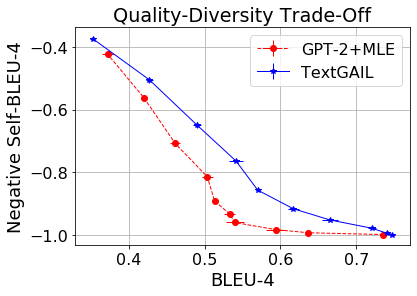

In [28]:
fig=plt.figure()
ax = fig.add_subplot(111)

# ax.scatter( - np.array(mle_bleu), np.array(mle_selfbleu), color='r')
# ax.scatter( - np.array(textgail_bleu), np.array(textgail_selfbleu), color='b')
# ax.plot(np.array(mle_bleu), np.array(mle_distinct), '-o', color='r')

ax.errorbar(np.mean(all_mle_bleu, axis=0), -np.mean(all_mle_selfbleu, axis=0), xerr=np.std(all_mle_bleu, axis=0), yerr=np.std(all_mle_selfbleu, axis=0), \
            marker='o', color='r', elinewidth=1, linewidth=1, linestyle="--")
# ax.scatter(np.array(textgail_bleu), np.array(textgail_distinct), color='b')
ax.errorbar(np.mean(all_textgail_bleu, axis=0), -np.mean(all_textgail_selfbleu, axis=0), xerr=np.std(all_textgail_bleu, axis=0), yerr=np.std(all_textgail_selfbleu, axis=0), \
            marker='*', color='b', elinewidth=1, linewidth=1)

ax.set_xlabel('BLEU-4', fontsize=18)
ax.set_ylabel('Negative Self-BLEU-4', fontsize=18)
ax.set_title(f'Quality-Diversity Trade-Off')
ax.legend(["GPT-2+MLE", "TextGAIL"])

# ax.set_yticks(np.arange(-1.0, -0.1, 0.2))
# ax.set_xticks(np.arange(0.25, 0.6, 0.05))

ax.grid("on")

# fig.savefig(f"{task_name}_qd-tradeoff.png", dpi=300, pad_inches=0.1, bbox_inches='tight')